## Acrobot

The [Acrobot](https://gymnasium.farama.org/environments/classic_control/acrobot/) is a classic problem in control theory. The environment consists of two links connected linearly to form a chain, with one end of the chain fixed. The joint between the two links is actuated. The goal is to apply torques on the actuated joint to swing the free end of the linear chain above a given height while starting from the initial state of hanging downwards.

- The action space is discrete, deterministic, and represents the torque applied on the actuated joint between the two links: (0) apply -1 torque, (1) apply 0 torque to the actuated joint, (2) apply 1 torque to the actuated joint
- The observation space is a 6-dimensional space with the sine and cosine of the two joint angles and their angular velocities.

![](./images/acrobot.png)

The goal is to have the free-end reach a designated target height in as few steps as possible, and as such all steps that do not reach the goal incur a reward of -1. Achieving the target height results in termination with a reward of 0. The reward threshold is -100.

1 - import the environment from Gymnasium and show it with a random policy

In [1]:
# YOUR CODE HERE

# You can get the environment from Gymnasium 'Acrobot-v1’; 
# In order to visually plot the environment you can import it 
# using render_mode="rgb_array". Get also th state size
# and action_size.

import gymnasium

acrobot = gymnasium.make('Acrobot-v1', render_mode="rgb_array");

state_size = acrobot.observation_space.shape;
action_size = acrobot.action_space.n;

print('State Space: ', state_size);
print('Action Space: ', action_size);

State Space:  (6,)
Action Space:  3


2 - Show the policy in action by rendering the environment several times after different decisions from a random policy:

In [2]:
# YOUR CODE HERE

# You can use the same function already used for the cartpole environment to 
# implement a random aget and to show the policy.

import numpy as np

def random_pi(state):
    return np.random.choice([0,2]);

In [3]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def show_policy(env, pi, n_episodes=1, max_steps=500):
    for _ in range(n_episodes):
        state = env.reset()[0];
        done = False;
        step = 0;
        while not done:
            action = pi(state);
            state, reward, terminated, truncated, info = env.step(action);
            if(terminated or truncated): done = True;
            clear_output(wait=True);
            plt.imshow(env.render());
            plt.show(); 
            if step > max_steps: break;
            step += 1;   

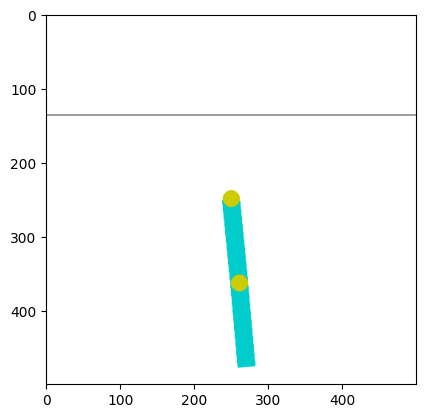

In [4]:
show_policy(acrobot, random_pi, n_episodes=1, max_steps=50);

3 - Create a neural network as a function approximator for the Q-function.

In [5]:
# YOUR CODE HERE

# Add the code for a neural network using the PyTorch library and
# the code of an optimizer as in the cartpole example

import torch;

dnn = torch.nn.Sequential(
        torch.nn.Linear(state_size[0], 512),  
        torch.nn.ReLU(),                           
        torch.nn.Linear(512, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, action_size));

optimizer = torch.optim.RMSprop(dnn.parameters(), lr=0.0001);

4 - Add the code for the experience buffer

In [6]:
# YOUR CODE HERE

# Add the code for the experience buffer as in the cartpole example

batch_size = 1024;

experience_type = np.dtype([
    ('state', np.float32, (state_size)), 
    ('action', np.int8),                  
    ('reward', np.float32),               
    ('next_state', np.float32, (state_size)),  
    ('failure', np.int8)                  
])

experiences_batch = np.empty(shape=(batch_size,), dtype=experience_type);

5 - Add the code of the exploration strategy based on epsilon-greedy method:

In [7]:
# YOUR CODE HERE

# Add the code for an exploration strategy based on the epsilon-greedy algorithm

import random

def epsilon_greedy(dnn, state, action_size, epsilon):
    if random.uniform(0,1) < epsilon:
        return np.random.randint(action_size);
    else:
        # convert the state into a tensor
        state = torch.FloatTensor(state).unsqueeze(0);
        # calculate q_values from the network
        q_values = dnn(state).detach();
        # act greedy
        action = np.argmax(q_values).data.numpy();
        return action;

6 - Add the code of to train the neural network usgin the collected experiences:

In [13]:
# YOUR CODE HERE

# Re-use the optimize method as in the cartpole example

def optimize(dnn, optimizer, batch, gamma, epochs):

    # prepare the experience as tensors
    states = torch.from_numpy(batch['state'].copy()).float();
    actions = torch.from_numpy(batch['action'].copy()).long();    
    next_states = torch.from_numpy(batch['next_state'].copy()).float();
    rewards = torch.from_numpy(batch['reward'].copy()).float();
    failures = torch.from_numpy(batch['failure'].copy()).long();

    for epoch in range(epochs):

        # get the values of the Q-function at next state
        # remember to detach, we need to treat these values as constants! 
        q_next = dnn(next_states).detach();
        
        # get the max value 
        max_q_next = q_next.max(1)[0];

        # one important step, often overlooked, is to ensure 
        # that failure states are grounded to zero
        max_q_next *= (1 - failures.float());

        # calculate the target 
        target = rewards + gamma * max_q_next;

        # finally, we get the current estimate of Q(s,a)
        q_current = torch.gather(dnn(states), 1, actions.unsqueeze(1)).squeeze(1);

        # create the errors
        td_error = target - q_current;

        # calculate the loss
        loss = td_error.pow(2).mean();

        # backward pass: compute the gradients
        optimizer.zero_grad();
        loss.backward();

        # update model parameters
        optimizer.step();

    return loss;


7 - Write the code of the NFQ algorithm

In [9]:
# YOUR CODE HERE

# Re-use the optimize method as in the cartpole example

def nfq(env, dnn, optimizer, batch, exploration_strategy,
        episodes, epochs, gamma, epsilon):

    # create a batch index
    index = 0;

    # train until for the maximum number of episodes
    for episode in range(episodes):
    
        # set return to 0
        discounted_return = 0;

        # reset the environment at the beginning of the episode
        state, done = env.reset()[0], False;

        # interact with the environment until the episode is done
        while not done:
                
            # select the action using the exploration policy
            action = exploration_strategy(dnn, state, action_size, epsilon);
            
            # perform the selected action
            next_state, reward, terminal, truncated, info = env.step(action);
            done = terminal or truncated;
            failure = terminal and not truncated;

            # store the experience
            batch[index] = (state, action, reward, next_state, failure);
            index += 1;
            
            # if the experience collected so far is enough...
            if index == len(batch):
                # optimize the model
                optimize(dnn, optimizer, batch, gamma, epochs);
                # and clear the buffer
                index = 0;
                batch = np.empty(shape=(len(batch),), dtype=experience_type);

            # update current state to next state
            state = next_state;
        
            # update the return
            discounted_return += reward;

    # prepare the policy by acting greedily:
    def pi(state):
        # convert the state into a tensor
        state = torch.FloatTensor(state).unsqueeze(0);

        # calculate q_values from the network
        q_values = dnn(state).detach();

        # act greedy
        action = np.argmax(q_values).data.numpy();
        
        return action;

    return pi;

8 - Apply NFQ to the environment 

In [14]:
# YOUR CODE HERE

# Apply NFQ to the acrobot environment 

# define hyperparameters values
episodes = 3000; 
batch_size = 1024; 
epochs = 40; 
gamma = 0.99;
epsilon = 0.5; 

# run the algorithm
pi = nfq(acrobot, dnn, optimizer, experiences_batch, epsilon_greedy,  
         episodes, epochs, gamma, epsilon);

9 - Evaluate the learned policy

In [15]:
# YOUR CODE HERE

# Write a function to evaluate its performance

def evaluate(env, pi, episodes=1):
    rewards = [];

    for episode in range(episodes):
        state, done = env.reset()[0], False;
        rewards.append(0);
        while not done:
            action = pi(state);
            state, reward, terminal, truncated, info = env.step(action)
            rewards[-1] += reward;
            done = terminal or truncated;

    return np.mean(rewards)

10 - Compare performace of random policy vs the one learned by the neural network

In [16]:
# YOUR CODE HERE

# Run the evaluation on the two policies and compare

random_score = evaluate(acrobot, random_pi, episodes=5);
agent_score = evaluate(acrobot, pi, episodes=5);

print("Random score", random_score);
print("Agent score", agent_score);

Random score -500.0
Agent score -92.4


11 - Show the policy behavior

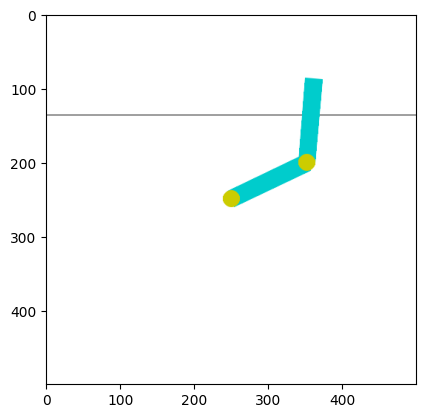

In [17]:
# YOUR CODE HERE

# You can show the policy learned by the agent using the show_policy function

show_policy(acrobot, pi, n_episodes=1)